<a href="https://colab.research.google.com/github/jtfreitas/NN_DL/blob/main/HW2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q optuna
!pip install -q PyQt5
!wget -q -O vae_tools.py https://raw.githubusercontent.com/jtfreitas/NN_DL/main/HW2/vae_tools.py

     |████████████████████████████████| 308 kB 7.3 MB/s 
     |████████████████████████████████| 209 kB 19.2 MB/s 
     |████████████████████████████████| 81 kB 6.9 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 47.0 MB/s 
     |████████████████████████████████| 146 kB 20.2 MB/s 


In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import random
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import utils as vutils
import optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
#Custom module with class definitions and model training utilities
#in order to keep notebook as procedural as possible
import vae_tools as vt

seed = 69420

# Use GPU if available
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device in use: {device}")

random.seed(seed)
torch.manual_seed(seed)
print(f"Random seed: {seed}")

/home/jtfreitas/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device in use: cuda
Random seed: 69420


In [4]:
#Load FashionMNIST datasets into memory

data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



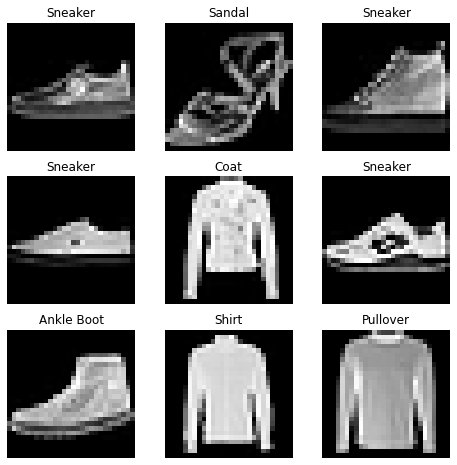

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
    }
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [6]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])
### Define dataloaders
train_dataloader = DataLoader(train_dataset,
                            batch_size=256, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset,
                            batch_size=256, shuffle=False)

# Include a subset used only for hyperparameter tuning to speed up process
HP_search_subset = torch.utils.data.Subset(train_dataset,
                                           list(range(len(train_dataset)//5 )))
HP_search_dataloader = DataLoader(HP_search_subset,
                                  batch_size = 120, shuffle = True)


# Set the train, test and subset transform
train_dataset.transform = MNIST_transform
test_dataset.transform = MNIST_transform
HP_search_subset.transform = MNIST_transform

# Show shapes of the data for quality control
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [50]:
def AE_objective(trial):
    """
    Performs a Bayesian-like hyperparameter search, using optuna's TPESampler.
    This generally allows a more thorough search compared to completely random
    sampling methods, while saving computation time compared to a complete grid
    search, especially considering the large range of filters considered.
    Overall, it's a good compromise between the certainty of grid-search and
    the efficiency of a random search.

    The best model is chosen based on the test data loss after five epochs.
    """

    # Parameters in the search include number of filters, size of the first
    # dense layer, shape of latent space, optimizer type, and finally its 
    # respective learning rate.

    params = {
        'conv1': {'filters': trial.suggest_int('filters1', 4, 8),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv2': {'filters': trial.suggest_int('filters2', 8, 16),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv3': {'filters': trial.suggest_int('filters3', 16, 32),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 0},
        # 'lin1': trial.suggest_int('lin1', 32, 64),
        'latent_space': 2#trial.suggest_int('latent_space', 2, 5)
    }

    model = vt.Autoencoder(28, params, device)
    model.to(device)

    lr = trial.suggest_loguniform('lr', 1e-5, 5e-4)
    params_to_optimize = [
        {'params': model.parameters()},
    ]
    optim_type = trial.suggest_categorical(
        'optimizer', ['Adam', 'Adagrad', 'AdamW'])
    optim = getattr(torch.optim, optim_type)(params_to_optimize, lr=lr)
    loss_fn = torch.nn.MSELoss()
    best_loss = vt.train_AE(
        model, 5, HP_search_dataloader, loss_fn, optim, device, verbose=False
        )[0] 
    # Choose only the [0]th element returned by train_AE, second corresponds
    # to the training epoch of the lowest loss.

    return best_loss

In [51]:
optuna.logging.set_verbosity(optuna.logging.FATAL) # Disable optuna's verbose logging
study = optuna.create_study(direction='minimize')  # Goal is to minimize the loss
study.optimize(AE_objective, n_trials = 20)        # 20 different models are tested
best_results = study.best_trial
print(f"Best result achieved in trial {best_results.number}"
      f" with a loss of {best_results.value}"
      f"\nwith parameters {best_results.params}")

[I 2022-07-11 08:50:43,952] A new study created in memory with name: no-name-785a3420-b60b-442f-9144-37a0205c81a6
[I 2022-07-11 08:50:50,450] Trial 0 finished with value: 0.08291656523942947 and parameters: {'filters1': 6, 'filters2': 13, 'filters3': 22, 'lr': 0.0002434891574084898, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.08291656523942947.
[I 2022-07-11 08:50:56,937] Trial 1 finished with value: 0.05110219493508339 and parameters: {'filters1': 8, 'filters2': 16, 'filters3': 28, 'lr': 0.00039962301875473447, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.05110219493508339.
[I 2022-07-11 08:51:03,437] Trial 2 finished with value: 0.0882628783583641 and parameters: {'filters1': 6, 'filters2': 10, 'filters3': 32, 'lr': 0.00010385399423161479, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.05110219493508339.
[I 2022-07-11 08:51:09,998] Trial 3 finished with value: 0.17169760167598724 and parameters: {'filters1': 6, 'filters2': 10, 'filters3': 28, 'lr': 1.158962464618

In [128]:
#Format the parameters according to the structure of the autoencoder
best_params = {
    'conv1': {'filters': study.best_params['filters1'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv2': {'filters': study.best_params['filters2'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv3': {'filters': study.best_params['filters3'],
                'kernel': 3,
                'stride': 2,
                'padding': 0},
    'lin1': study.best_params['lin1'],
    'latent_space': 2 #study.best_params['latent_space']
}

#Instantiate the autoencoder, set up torch loss and optimizer
best_AE = vt.Autoencoder(28, best_params, device)

loss_fn = torch.nn.MSELoss()
params_to_optimize = [
    {'params': best_AE.parameters()},
]

optim = getattr(torch.optim, study.best_params['optimizer'])(
    params_to_optimize, lr=study.best_params['lr'], weight_decay=1e-5)

best_AE.to(device)
loss_fn.to(device)

MSELoss()

K-fold cross-validation

In [117]:
k_folds = 6
num_epochs = 20
cv_losses = vt.CV_AE(
    k_folds, best_AE,
    num_epochs, train_dataloader, loss_fn, optim, device)

Fold 1/6...	Done.
Fold 2/6...	Done.
Fold 3/6...	Done.
Fold 4/6...	Done.
Fold 5/6...	Done.
Fold 6/6...	Done.


Text(0.5, 0.98, 'K-fold CV timeline')

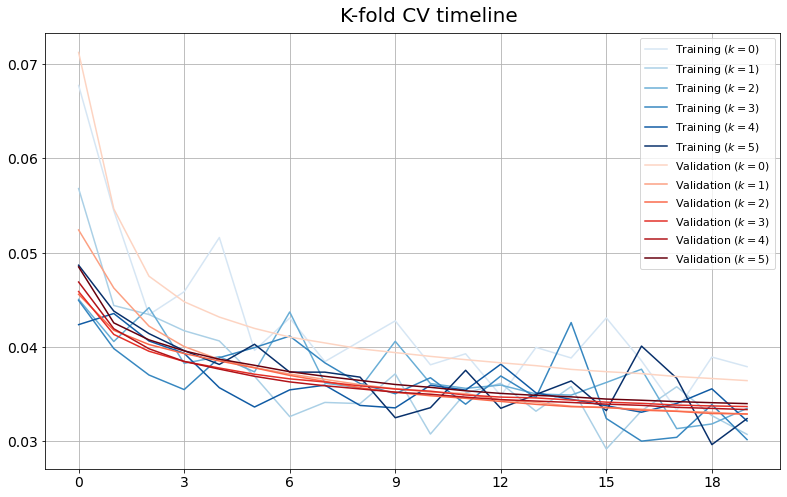

In [120]:
fig, ax = plt.subplots(1,1, figsize=(12, 7), tight_layout=dict(rect=(0,0,.92,.95)))

for loss, loss_type, cmap in zip(cv_losses,
                                 ['Training', 'Validation'],
                                 ['Blues', 'Reds']):
    cmap = cm.get_cmap(cmap)
    for fold in range(k_folds):
        ax.plot(range(num_epochs), loss[fold],
                color=cmap((fold+1)/k_folds),
                label=f'{loss_type} $(k={fold})$')
ax.grid()
ax.legend(loc='upper right', fontsize=11)
ax.tick_params(axis='both', labelsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle('K-fold CV timeline', fontsize=20)

In [121]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(best_AE)

11851

In [129]:
best_AE.reset_weights()

vt.train_AE(
    best_AE, num_epochs, train_dataloader, loss_fn, optim, device,
    test_dataloader=test_dataloader,
    save_dir=f'models/best_AE_z{best_AE.latent_space}', verbose=True)

EPOCH 1/20 : 
partial train loss (single batch): 0.0718 Validation loss: 0.072314
EPOCH 2/20 : 
partial train loss (single batch): 0.0495 Validation loss: 0.051247
EPOCH 3/20 : 
partial train loss (single batch): 0.0484 Validation loss: 0.045908
EPOCH 4/20 : 
partial train loss (single batch): 0.0471 Validation loss: 0.043359
EPOCH 5/20 : 
partial train loss (single batch): 0.0410 Validation loss: 0.041853
EPOCH 6/20 : 
partial train loss (single batch): 0.0435 Validation loss: 0.040833
EPOCH 7/20 : 
partial train loss (single batch): 0.0385 Validation loss: 0.040139
EPOCH 8/20 : 
partial train loss (single batch): 0.0404 Validation loss: 0.039462
EPOCH 9/20 : 
partial train loss (single batch): 0.0372 Validation loss: 0.038953
EPOCH 10/20 : 
partial train loss (single batch): 0.0394 Validation loss: 0.038535
EPOCH 11/20 : 
partial train loss (single batch): 0.0373 Validation loss: 0.038127
EPOCH 12/20 : 
partial train loss (single batch): 0.0369 Validation loss: 0.037861
EPOCH 13/20 :

(tensor(0.0359), 19)

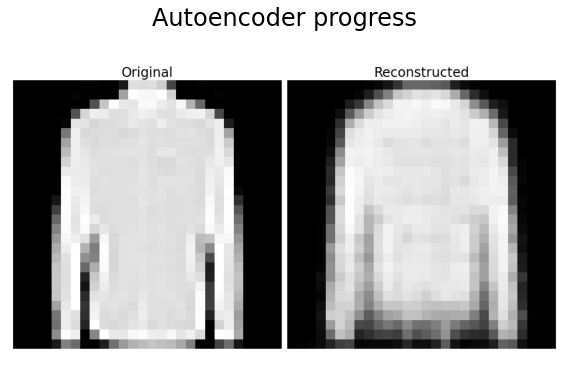

In [124]:
def read_img(i):
    """
    Handles the exception caused by plots that were not saved because the
    model performance worsened on the respective epoch.
    """
    try:
        return mpimg.imread(
            f'models/best_AE_z{best_AE.latent_space}/plots/t={i}.jpg')
    except FileNotFoundError:
        return None

fig = plt.figure(figsize=(8,6), tight_layout='pad')
fig.suptitle('Autoencoder progress', fontsize=24)
plt.axis("off")
img_list = [read_img(i) for i in range(num_epochs)]

#Checks if element in img_list is an array, skips it in case it isn't.
ims = [[plt.imshow(i, animated=True)] 
       for i in img_list if type(i) == np.ndarray]
ani = animation.ArtistAnimation(
    fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

# Supervised learning on latent space

In [130]:
class_params = {
    'lin1' : (best_AE.latent_space, 70),
    'lin2' : (70, 120),
    'lin3' : (120, 100),
    'lin4' : (100, 10),
}

classifier = vt.Classifier(class_params, device)
classifier.to(device)

classifier_loss = nn.CrossEntropyLoss()
classifier_loss.to(device)
optimizer = torch.optim.Adam(
    classifier.parameters(), lr=1e-4, weight_decay=1e-5)
no_epochs = 50
vt.train_model(
    classifier, train_dataloader, test_dataloader,
    no_epochs, classifier_loss, optimizer, AE=best_AE)

Loss = 1.60571
Loss = 1.50481
Loss = 1.45382
Loss = 1.41151
Loss = 1.37593
Loss = 1.35211
Loss = 1.32989
Loss = 1.30901
Loss = 1.29360
Loss = 1.27415
Loss = 1.25356
Loss = 1.23739
Loss = 1.22027
Loss = 1.20450
Loss = 1.18700
Loss = 1.17540
Loss = 1.15983
Loss = 1.14518
Loss = 1.13292
Loss = 1.12056
Loss = 1.10934
Loss = 1.10212
Loss = 1.09361
Loss = 1.08522
Loss = 1.07937
Loss = 1.07285
Loss = 1.06851
Loss = 1.06196
Loss = 1.06065
Loss = 1.05798
Loss = 1.05451
Loss = 1.05116
Loss = 1.04936
Loss = 1.04910
Loss = 1.04463
Loss = 1.04378
Loss = 1.04379
Loss = 1.04378
Loss = 1.03897
Loss = 1.04063
Loss = 1.03424
Loss = 1.03960
Loss = 1.03540
Loss = 1.03887
Loss = 1.04146
Loss = 1.02697
Loss = 1.03865
Loss = 1.02795
Loss = 1.02930
Loss = 1.03184


1.0318405628204346

In [131]:
class_params = {
    'lin1' : (28**2, 20),
    'lin2' : (20, 120),
    'lin3' : (120, 100),
    'lin4' : (100, 10),
}

classifier_noAE = vt.Classifier(class_params, device)

classifier_noAE.to(device)
classifier_noAE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_noAE.parameters(), lr=1e-4, weight_decay=1e-5)
no_epochs = 50
vt.train_model(classifier_noAE, train_dataloader, test_dataloader, no_epochs, classifier_noAE_loss, optimizer)

Loss = 1.25896
Loss = 0.88100
Loss = 0.76864
Loss = 0.71093
Loss = 0.66254
Loss = 0.62222
Loss = 0.59072
Loss = 0.57082
Loss = 0.55169
Loss = 0.53986
Loss = 0.52724
Loss = 0.51848
Loss = 0.51147
Loss = 0.50267
Loss = 0.49941
Loss = 0.49215
Loss = 0.48778
Loss = 0.48540
Loss = 0.48263
Loss = 0.47844
Loss = 0.47261
Loss = 0.47102
Loss = 0.46889
Loss = 0.46617
Loss = 0.46567
Loss = 0.46011
Loss = 0.46248
Loss = 0.45855
Loss = 0.45697
Loss = 0.45539
Loss = 0.45204
Loss = 0.45308
Loss = 0.45078
Loss = 0.44811
Loss = 0.44858
Loss = 0.44813
Loss = 0.44937
Loss = 0.44707
Loss = 0.44354
Loss = 0.44249
Loss = 0.44438
Loss = 0.44185
Loss = 0.44324
Loss = 0.44041
Loss = 0.44182
Loss = 0.43984
Loss = 0.43879
Loss = 0.43916
Loss = 0.43704
Loss = 0.43616


0.4361564517021179

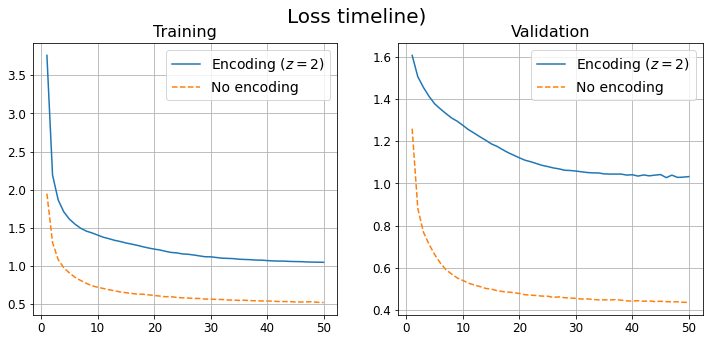

In [134]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
model_list = [classifier, classifier_noAE]
label_list = [('-', f'Encoding $(z={best_AE.latent_space})$'), ('--', 'No encoding')]
for label, model in zip(label_list, model_list):
    axs[0].plot(model.history['epoch'], model.history['train'],
           label[0], label=label[1])
    axs[1].plot(model.history['epoch'], model.history['valid'],
        label[0], label=label[1])
    
axs[0].set_title('Training', fontsize=16)
axs[1].set_title('Validation', fontsize=16)
fig.suptitle(f'Loss timeline)', fontsize=20)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.legend(fontsize=14)
    ax.grid()


In [169]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
pca = PCA(n_components=3)

encoded_samples = []
samples = []
for sample in test_dataset:
    samples.append(sample[0].squeeze(0).flatten().cpu().numpy())
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    best_AE.encoder.eval()
    with torch.no_grad():
        encoded_img = best_AE.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_TSNE = tsne.fit_transform(samples)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [181]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_theme()

%matplotlib tk
fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(encoded_samples_reduced_PCA[:,0],
               encoded_samples_reduced_PCA[:,1],
               encoded_samples_reduced_PCA[:,2],
               c=encoded_samples.label.to_numpy(),
            cmap="tab10", edgecolor='white', linewidths=0.5)

ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(encoded_samples_reduced_TSNE[:,0],
            encoded_samples_reduced_TSNE[:,1],
            encoded_samples_reduced_TSNE[:,2],
            c=encoded_samples.label.to_numpy(),
            cmap="tab10", edgecolor='white', linewidths=0.5)

ax1.set_title("PCA")
ax2.set_title("t-SNE")

label_names = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
             'Sneaker','Bag','Boot']

legend = fig.legend(sc1.legend_elements()[0], label_names,
                    title="Classes", loc='right',
                    fontsize=13, labelspacing=1.1)

fig.add_artist(legend)
fig.show()

ImportError: ignored

In [142]:
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,27.576672,-12.539566,9
1,-6.301218,-12.602009,2
2,24.453300,-71.063950,1
3,32.400917,-81.191811,1
4,10.093970,-13.187638,6
...,...,...,...
9995,20.723064,3.055402,9
9996,33.881676,-71.133698,1
9997,17.578894,-27.717621,8
9998,32.252762,-82.326729,1


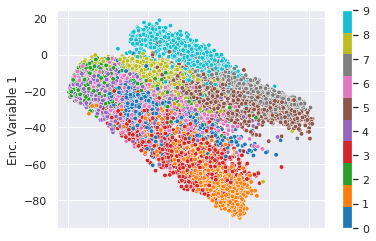

In [150]:
encoded_samples.plot.scatter(
    x = 'Enc. Variable 0',
    y = 'Enc. Variable 1',
    c=encoded_samples.label.to_numpy(),
    cmap='tab10', edgecolor='white', linewidths=0.5)

# Generating fake samples

In [182]:
fake_latents = torch.randn((100, best_AE.latent_space), device=best_AE.device)
best_AE.decoder.eval()
with torch.no_grad():
    fake_samples = best_AE.decoder(fake_latents)

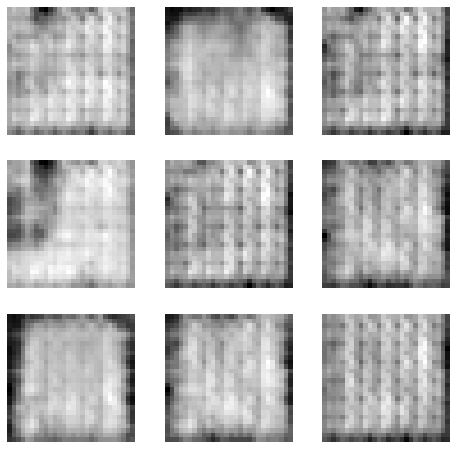

In [183]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fake_samples), size=(1,)).item()
    img = fake_samples[sample_idx].cpu().detach().numpy()
    figure.add_subplot(rows, cols, i)
    # plt.title()
    plt.axis("off")
    plt.imshow(img.squeeze(0), cmap="gray")
plt.show()

# GAN

In [ ]:
gan_study = optuna.create_study(direction='minimize')
gan_study.optimize(GAN_objective)

[I 2022-06-21 18:16:27,451] A new study created in memory with name: no-name-c536673a-1293-4fad-abcc-f989fd1dfa22
[W 2022-06-21 18:19:35,855] Trial 0 failed, because the number of the values 2 did not match the number of the objectives 1.
[W 2022-06-21 18:23:58,407] Trial 1 failed, because the number of the values 2 did not match the number of the objectives 1.
[W 2022-06-21 18:25:35,614] Trial 2 failed, because the number of the values 2 did not match the number of the objectives 1.


In [ ]:
n_classes = len(train_dataset.targets.unique())
params = {'latent_space' : 100,
          'G_filters' : 128,
          'D_filters' : 32,
          'n_channels' : 1,
          'opt' : 'Adam',
          'lr' : 1e-4}

gan = vt.GAN(params, device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

gan.to(device)
loss_history, img_list = vt.train_GAN(
    gan, train_dataloader, 50, criterion, device, saturating=False, snapshots = True)

[1/50]	Loss_D: 0.4143, 	Loss_G: 1.9899, 	D(x): 1.7801 	D(G(z)): -1.4681 / -1.8276
[2/50]	Loss_D: 0.5194, 	Loss_G: 2.4041, 	D(x): 1.7420 	D(G(z)): -1.3610 / -2.2801
[3/50]	Loss_D: 0.4489, 	Loss_G: 2.4095, 	D(x): 2.2150 	D(G(z)): -1.5505 / -2.2750
[4/50]	Loss_D: 0.0526, 	Loss_G: 4.3918, 	D(x): 4.3749 	D(G(z)): -3.9687 / -4.3742
[5/50]	Loss_D: 0.2286, 	Loss_G: 3.4725, 	D(x): 2.4779 	D(G(z)): -2.6010 / -3.4184
[6/50]	Loss_D: 0.2394, 	Loss_G: 3.0293, 	D(x): 2.6842 	D(G(z)): -2.7015 / -2.9501
[7/50]	Loss_D: 0.1142, 	Loss_G: 3.6158, 	D(x): 3.5194 	D(G(z)): -3.1496 / -3.5713
[8/50]	Loss_D: 0.2089, 	Loss_G: 3.4731, 	D(x): 2.7943 	D(G(z)): -2.8351 / -3.4284
[9/50]	Loss_D: 0.2437, 	Loss_G: 2.5964, 	D(x): 2.8177 	D(G(z)): -2.1807 / -2.4873
[10/50]	Loss_D: 0.4134, 	Loss_G: 2.3999, 	D(x): 2.1531 	D(G(z)): -1.8950 / -2.2628
[11/50]	Loss_D: 0.2468, 	Loss_G: 3.0918, 	D(x): 2.7696 	D(G(z)): -2.4226 / -3.0250
[12/50]	Loss_D: 0.5166, 	Loss_G: 2.1394, 	D(x): 1.5795 	D(G(z)): -1.7418 / -1.9571
[13/50]	Loss_

In [ ]:
gan.zero_grad()
test_data = test_dataset[0][0].unsqueeze(0).to(device)
D_out = gan.netD(test_data)

label = torch.tensor([1],
                dtype=torch.float, device=device).reshape((1,1,1,1))
    

criterion(D_out, label)

tensor(0.3994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
rand_noise = torch.randn(64, gan.latent_space, 1, 1, device=device)

gen_fakes = gan.netG(rand_noise).cpu().detach().numpy()[0]


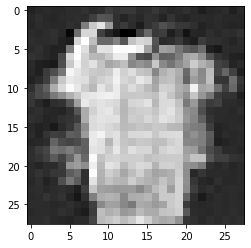

In [ ]:
plt.imshow(gen_fakes[0], cmap= 'gist_gray')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in gen_fakes]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(params['latent_space'], params['G_filters'] * 4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 4),
            nn.ReLU(True),
            # state size. (G_filters*8, 4, 4)
            nn.ConvTranspose2d(params['G_filters'] * 4, params['G_filters'] * 2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 2),
            nn.ReLU(True),
            # state size. (G_filters*4, 8, 8)
            nn.ConvTranspose2d( params['G_filters'] * 2, params['G_filters'], 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters']),
            nn.ReLU(True),
            # state size. (G_filters*2, 16, 16)
            nn.ConvTranspose2d( params['G_filters'], params['n_channels'], 3, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels, 64, 64)
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(params).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
#netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, params, conditional=False):
        super(Discriminator, self).__init__()
        self.conditional=conditional
        self.main = nn.Sequential(
            # input is (1,28,28)
            nn.Conv2d(in_channels=params['n_channels'], out_channels=params['D_filters'],
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters, 14, 14)
            nn.Conv2d(in_channels=params['D_filters'], out_channels=params['D_filters'] * 2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*2, 7, 7)
            nn.Conv2d(in_channels=params['D_filters'] * 2, out_channels=params['D_filters'] * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*4, 3, 3)
            nn.Conv2d(in_channels = params['D_filters']* 4, out_channels=1,
                      kernel_size = 4, stride=2, padding=1)
            # scalar output (1, 1, 1)
        )

    def forward(self, input):
        if self.conditional:
            pass

        else:
            return self.main(input)

In [ ]:
class GAN(nn.Module):
    def __init__(self, params, device, conditional=False):
        super(GAN, self).__init__()
        self.conditional = conditional
        self.latent_space = params['latent_space']
        self.netG = Generator(params)
        self.netD = Discriminator(params, conditional = self.conditional)
        self.epochs_trained = 0
        self.device = device
        
        self.optimizerD = getattr(torch.optim, params['opt'])(self.netD.params_to_optimize(), lr=params['lr'])
        self.optimizerG = getattr(torch.optim, params['opt'])(self.netG.params_to_optimize(), lr=params['lr'])


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


(1, 1, 1, 1)

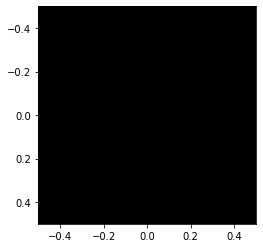

In [ ]:
# Create the Discriminator
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
netD = Discriminator(params).to(device)
img = img.to(device)
dsc_img = netD(img).detach().cpu().numpy()
img.detach()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# Print the model
print(netD)
plt.imshow(dsc_img[0][0], cmap='gist_gray')

dsc_img.shape

In [ ]:
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, params['latent_space'], 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D

beta1 = 0.5
optimizerD = torch.optim.Adam(netD.parameters(), lr=params['lr'], betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=params['lr'], betas=(beta1, 0.999))

In [ ]:
getattr(torch.optim, "Adam")

torch.optim.adam.Adam

In [ ]:
# Training Loop
# Lists to keep track of progress

num_epochs = 30
img_list = []
G_losses = []
D_losses = []
iters = 0
latent_space = params['latent_space']
saturating = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(1, num_epochs+1):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if saturating:
            # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
            label.fill_(fake_label)
        else:
            # Non-saturating loss: fake labels are real for generator cost
            label.fill_(real_label)

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output

        if saturating:
            errG = -criterion(output, label)  # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label)  # Non-saturating loss
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

        if (iters % 500 == 0) or ((epoch == num_epochs) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\r')
    print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\n')

Starting Training Loop...
[1/30]	Loss_D: 1.3878, 	Loss_G: 0.7139, 	D(x): 0.0236 	D(G(z)): 0.0184 / -0.0385
[2/30]	Loss_D: 1.3777, 	Loss_G: 0.7141, 	D(x): 0.0153 	D(G(z)): -0.0052 / -0.0402
[3/30]	Loss_D: 1.2067, 	Loss_G: 0.8927, 	D(x): -0.1324 	D(G(z)): -0.6342 / -0.3488
[4/30]	Loss_D: 1.0395, 	Loss_G: 1.0993, 	D(x): 0.4360 	D(G(z)): -0.4174 / -0.6759
[5/30]	Loss_D: 0.9452, 	Loss_G: 0.9463, 	D(x): 0.4824 	D(G(z)): -0.6217 / -0.4139
[6/30]	Loss_D: 0.8098, 	Loss_G: 0.8868, 	D(x): 0.3327 	D(G(z)): -1.3411 / -0.3264
[7/30]	Loss_D: 0.8609, 	Loss_G: 1.2462, 	D(x): 0.9594 	D(G(z)): -0.4758 / -0.8872
[8/30]	Loss_D: 0.8652, 	Loss_G: 0.9858, 	D(x): 0.5119 	D(G(z)): -0.9138 / -0.4751
[9/30]	Loss_D: 0.8863, 	Loss_G: 0.9549, 	D(x): 0.2619 	D(G(z)): -1.2449 / -0.4176
[10/30]	Loss_D: 0.8801, 	Loss_G: 1.0184, 	D(x): 0.0411 	D(G(z)): -1.8647 / -0.5207
[11/30]	Loss_D: 0.8700, 	Loss_G: 2.2142, 	D(x): 1.7060 	D(G(z)): -0.1106 / -2.0702
[12/30]	Loss_D: 0.5161, 	Loss_G: 1.6426, 	D(x): 1.3657 	D(G(z)): -1.38

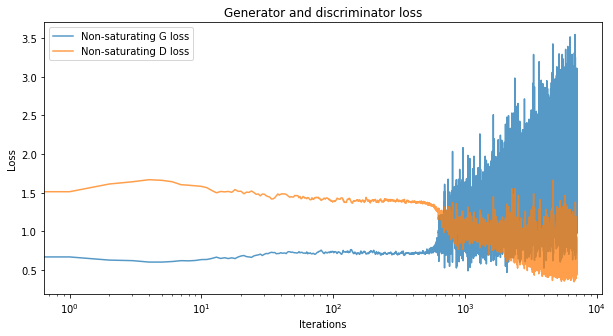

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator loss")
plt.plot(G_losses,label="Non-saturating G loss", alpha=0.75)
plt.plot(D_losses,label="Non-saturating D loss", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.xscale("log")
plt.legend()
plt.show()

In [ ]:
# Visualize results with saturating G loss
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

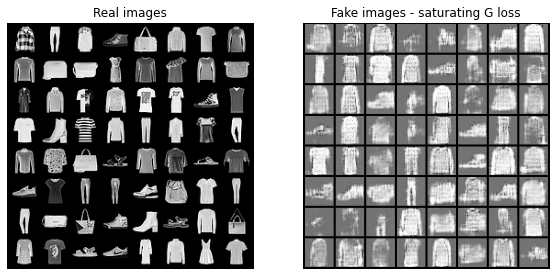

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Fake images - saturating G loss")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

In [ ]:
# Training Loop
saturating = False
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################


        if saturating:
            label.fill_(fake_label) # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
        else:
            label.fill_(real_label) # Non-saturating loss: fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        
        if saturating:
            errG = -criterion(output, label) # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label) # Non-saturating loss

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)